# Circuit tensor network simulation & comparison with statevector

# Circuit generation

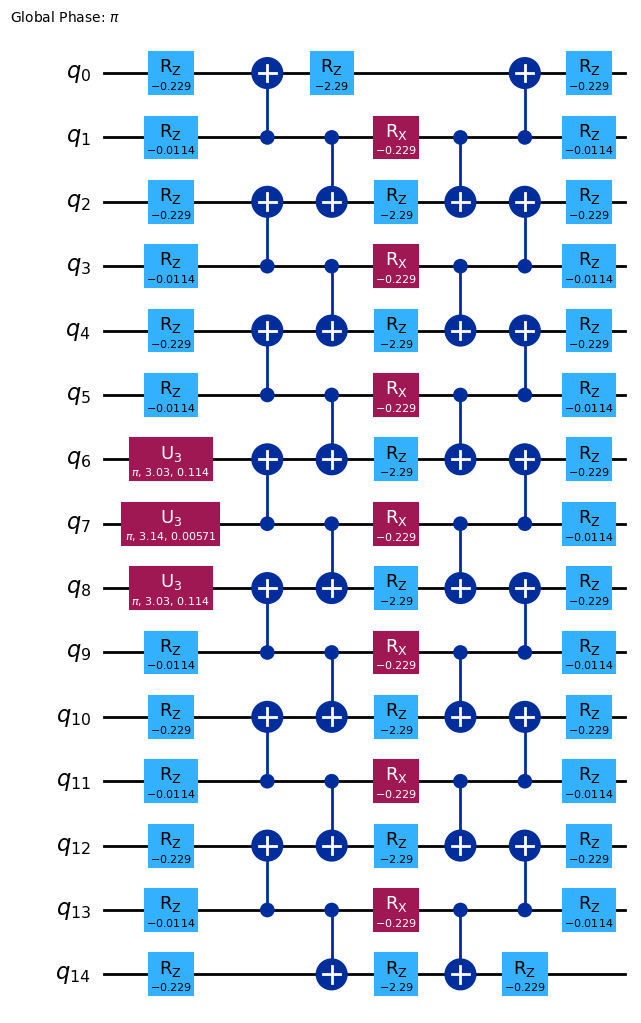

In [1]:
L = 8
J = 1
h = 0.05
lamb = 0.5
g = 5
x_basis = False

particle_pair_left_position = 3
particle_pair_length = 1

final_time = 8
layers = 35
measure_every_layers = 1

import z2chain.circs as circs

logical_circs = circs.particle_pair_quench_simulation_circuits(L, J, h, lamb, particle_pair_left_position, particle_pair_length, final_time, layers, g=g, measure_every_layers=measure_every_layers, x_basis=x_basis)
logical_circs[1].draw(output="mpl")

## Simulation

In [2]:
from utils.sexec import execute_simulation_estimator_batch
from z2chain.operators import local_pauli_z
from functools import partial

estimator_options = {
    "default_precision": 0
}

mps_simulator_options = {
    "method": "matrix_product_state",
    "matrix_product_state_max_bond_dimension": None,
    "matrix_product_state_truncation_threshold": 1e-16
}

sv_simulator_options = {
    "method": "statevector"
}

observables_generating_funcs = [partial(local_pauli_z, qubit_ind=i) for i in range(2*L-1)]

mps_jobs = execute_simulation_estimator_batch(mps_simulator_options, estimator_options, logical_circs, observables_generating_funcs)
sv_jobs = execute_simulation_estimator_batch(sv_simulator_options, estimator_options, logical_circs, observables_generating_funcs)

## Plots

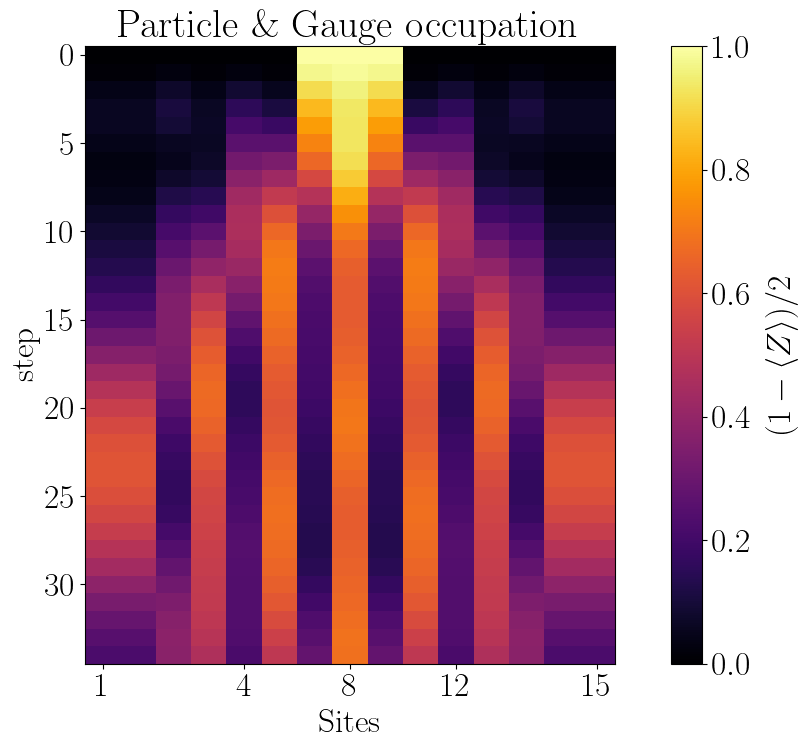

In [3]:
from z2chain.plotting import x_t_plot

x_t_plot(sv_jobs)

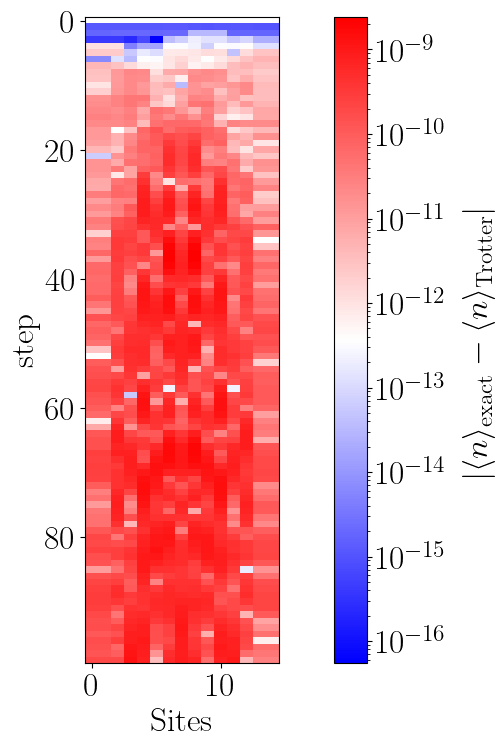

In [5]:
from z2chain.plotting import discrepancies_plot

discrepancies_plot(sv_jobs, mps_jobs)

### Differences are minimal ✅

# Large simulation

## Circuit generation

Longest circuit has 100 2-qb depth


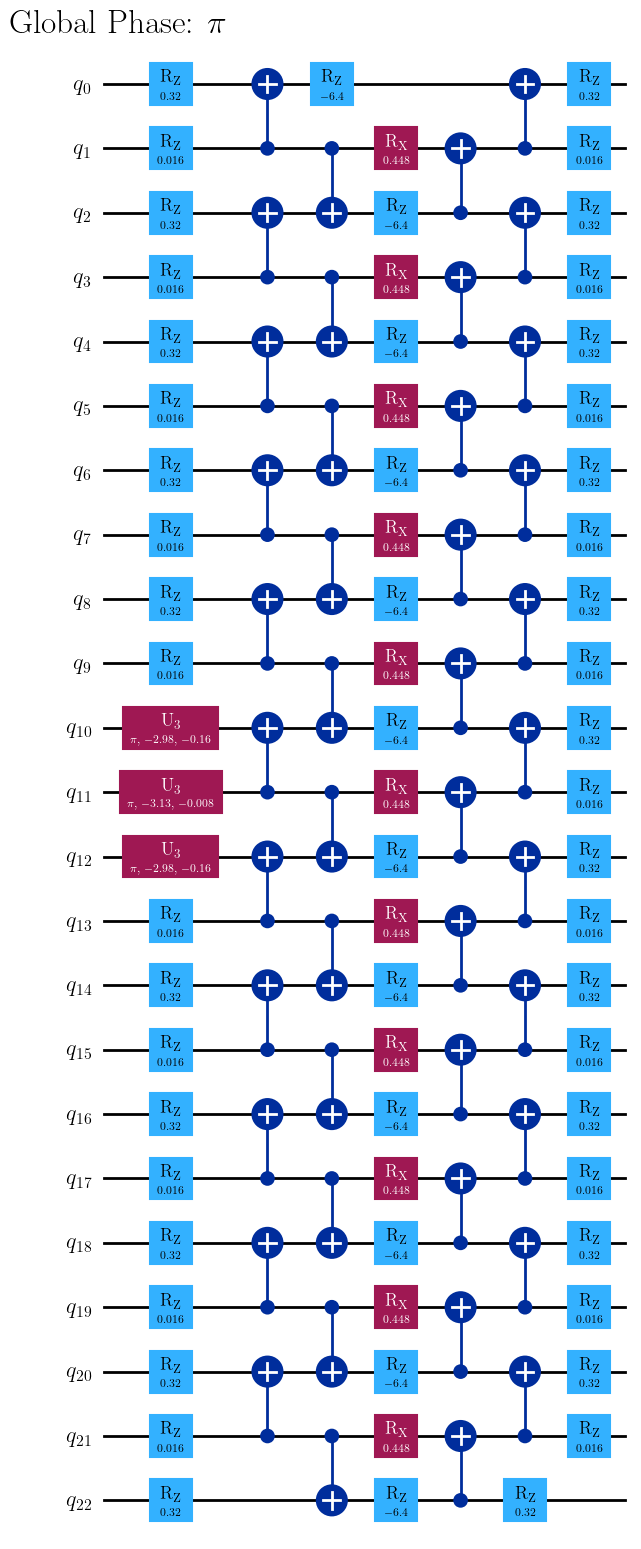

In [7]:
L = 12
J = 1
h = 0.05
lamb = 0.7
g = 10

x_basis = False

particle_pair_left_position = L//2 - 1
particle_pair_length = 1

final_time = 8
layers = 25
measure_every_layers = 1

import z2chain.circs as circs

logical_circs = circs.particle_pair_quench_simulation_circuits(L, J, h, lamb, particle_pair_left_position, particle_pair_length, final_time, layers, g=g, measure_every_layers=measure_every_layers, x_basis=x_basis)
longest_2qb_depth = logical_circs[-1].depth(lambda x: len(x.qubits) == 2)
print(f"Longest circuit has {longest_2qb_depth} 2-qb depth")
logical_circs[1].draw(output="mpl")

## Simulation

In [23]:
from z2chain.plotting import save_site_gauge_observable_matrix, load_site_gauge_observable_matrix
from z2chain.operators import local_pauli_z, local_pauli_x
from utils.sexec import execute_simulation_estimator_batch
from functools import partial
import os

estimator_options = {
    "default_precision": 0
}

mps_simulator_options = {
    "method": "matrix_product_state",
    "matrix_product_state_max_bond_dimension": 256,
    "matrix_product_state_truncation_threshold": 1e-8,
    "max_parallel_threads": 8,
    "max_parallel_experiments": 8
}

filepath = f"Results/tncirc_z2pairquench_maxt_{final_time}_steps_{layers}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_g_{g}_pp_{particle_pair_left_position}_pl_{particle_pair_length}_xbasis_{x_basis}_bd_{mps_simulator_options["matrix_product_state_max_bond_dimension"]}_prec_{estimator_options['default_precision']}.txt"

if os.path.exists(filepath):
    to_plot = load_site_gauge_observable_matrix(filepath)
else:
    observables_generating_funcs = [partial(local_pauli_z if not x_basis else local_pauli_x, qubit_ind=i) for i in range(2*L-1)]
    to_plot = execute_simulation_estimator_batch(mps_simulator_options, estimator_options, logical_circs, observables_generating_funcs)
    save_site_gauge_observable_matrix(to_plot, filepath)

## Plots

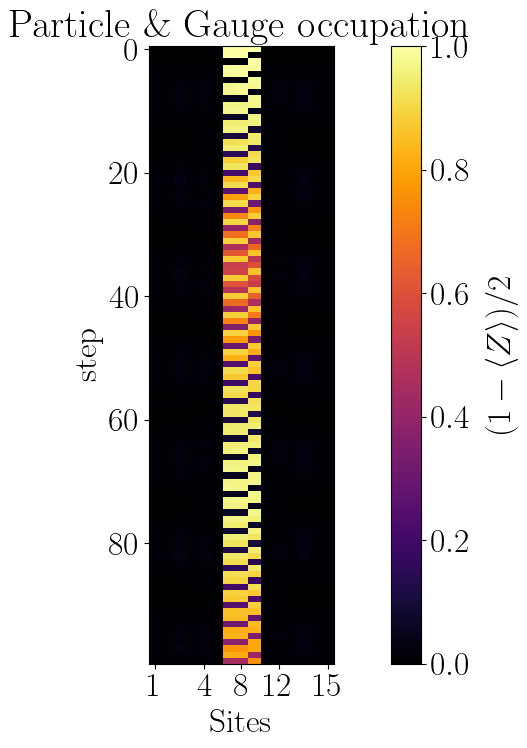

In [24]:
from z2chain.plotting import x_t_plot

x_t_plot(to_plot, filepath=os.path.join("Plots", os.path.basename(os.path.split(filepath)[1])) + ".png")

In [3]:
from utils.hexec import create_estimator_options
from utils.hexec import ExecDB

# L_arr = [8, 16, 24, 32, 40, 48, 50]
L_arr = [6]
J = 1
h = 0.05
lamb = 0.7
g = 5

x_basis = False

particle_pair_left_positions = [L//2 - 1 for L in L_arr]
particle_pair_length = 1

final_time = 8
steps = 35

shots = [10000]
optimization_levels = [0]
zne_extrapolator_levels = [("linear", [1, 1.2, 1.5])] #[None, ("linear", [1, 1.2, 1.5]), ("linear", [1, 2, 3]), ("linear", [1, 3, 5])]
measure_mitigations = [True]
dd_sequences = ["XY4"]
twirlings = [True]

execution_database = "z2_chain_jobs.json"
job_db = ExecDB(execution_database)

from qiskit_ibm_runtime import QiskitRuntimeService
from cobos.tokens import ibm_token, group_instance
# from fradm.tokens import ibm_token, group_instance
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
from qiskit_aer import AerSimulator
import numpy as np

channel = "ibm_quantum"
# device = "ibm_kyiv"
device = "ibm_brisbane"
# device = "ibm_fez"
# device = "ibm_sherbrooke"
# device = "ibm_torino"

eplg_absolute = 1.86e-2

service = QiskitRuntimeService(channel=channel, token=ibm_token, instance=group_instance)
backend = FakeBrisbane()
# backend = AerSimulator(method="statevector")

from z2chain.circs import physical_particle_pair_quench_simulation_circuits, erradj_particle_pair_quench_simulation_circuits
from z2chain.operators import local_pauli_z, local_pauli_x
from utils.hexec import get_backend_best_qubit_chain
from functools import partial

optimization_level = 2

circuits = [] # circuits[L][t]
observable_generating_funcs = [] #observable_generating_funcs[L][i]

observable_name = "Occupation numbers" + (" X" if x_basis else " Z")

estimator_options_dict = create_estimator_options(shots, optimization_levels, zne_extrapolator_levels, measure_mitigations, dd_sequences, twirlings)
extra_options = [{"backend": device, "L": L, "J": J, "h": h, "λ":lamb, "g": g, "particle_pair_position": pp_pos, "particle_pair_length": particle_pair_length, "final_time": final_time, "eplg": eplg_absolute} for L, pp_pos in zip(L_arr, particle_pair_left_positions)]

for L, pp_ps in zip(L_arr, particle_pair_left_positions):
    # qubits_inds = get_backend_best_qubit_chain(backend, 2*L-1)
    qubits_inds = np.arange(2*L-1)
    physical_circuits = erradj_particle_pair_quench_simulation_circuits(L, J, h, lamb, pp_ps, particle_pair_length, final_time, steps, backend, optimization_level, eplg_absolute, g, qubits_inds, x_basis)
    observable_generating_funcs.append([partial(local_pauli_z if not x_basis else local_pauli_x, qubit_ind=i) for i in range(2*L-1)])
    circuits.append(physical_circuits)

circuits[0][1].draw(output="mpl", idle_wires=False)

from utils.sexec import execute_simulation_estimator_batch
from z2chain.operators import local_pauli_z
from functools import partial

estimator_options = {
    "default_precision": 1e-3
}

mps_simulator_options = {
    "method": "matrix_product_state",
    "matrix_product_state_max_bond_dimension": None,
    "matrix_product_state_truncation_threshold": 1e-16
}

sv_simulator_options = {
    "method": "statevector"
}

observables_generating_funcs = [partial(local_pauli_z, qubit_ind=i) for i in range(2*L-1)]

from utils.hexec import execute_estimator_batch

sv_jobs = execute_estimator_batch(backend, estimator_options, circuits[0], observable_generating_funcs[0])

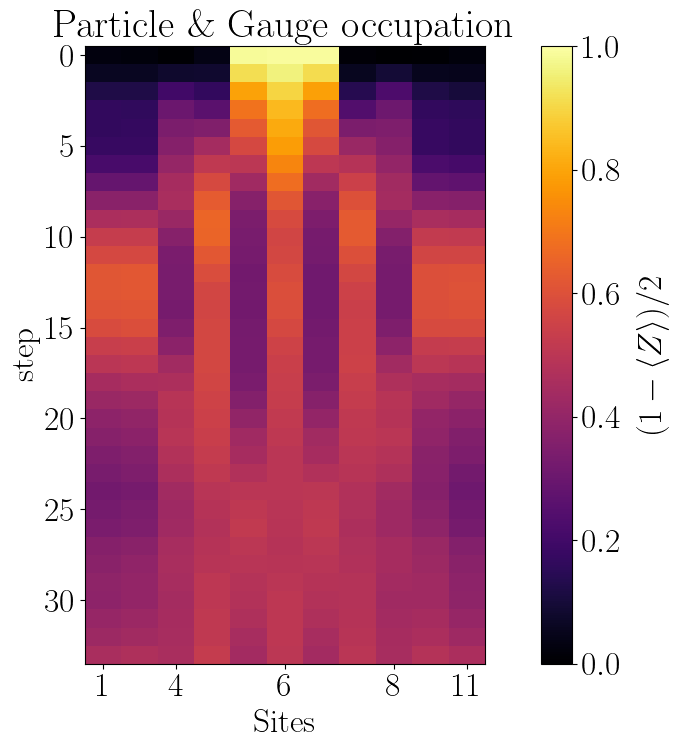

In [4]:
from z2chain.plotting import x_t_plot

x_t_plot(sv_jobs)